In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings

import allinone as aio

%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option("display.float_format", "{:.3f}".format)
plt.style.use('ggplot')

In [50]:
df = pd.read_csv('hmelq_clean.csv')

In [51]:
df.head(3)

,bad,loan,mortdue,value,reason,job,yoj,derog,delinq,clage,ninq,clno,debtinc
0,0,29.311,64.074,16.199,HomeImp,Other,28.000,0.000,0.000,18.711,0.000,14.000,13.321
1,0,19.771,112.857,16.569,DebtCon,Other,2.000,0.000,0.000,18.002,0.000,25.000,13.443
2,0,21.390,86.871,14.924,DebtCon,Other,5.000,0.000,0.000,15.992,2.000,9.000,11.077


### Dummy

In [52]:
dfCopy = df.copy()
x_ = dfCopy[['bad','job','reason']]

#StandardScaler
scale_col = pd.DataFrame(StandardScaler().fit_transform(dfCopy[['loan', 'mortdue', 'value', 'yoj', 'derog', 'delinq', 'clage', 'ninq', 'clno', 'debtinc']]),
            columns=['loan', 'mortdue', 'value', 'yoj', 'derog', 'delinq', 'clage', 'ninq', 'clno', 'debtinc'])
dfScale = pd.concat([x_, scale_col], axis=1)

#Dummy
dms = pd.get_dummies(dfCopy[['reason','job']])
Xs_ = dfScale.drop(['reason','job'], axis=1)
dfScale_dummy = pd.concat([Xs_,dms], axis=1)
dfScale_dummy = dfScale_dummy.drop(['reason_DebtCon'], axis=1)

dfDummy = dfScale_dummy.copy()

In [53]:
dfDummy.head(3)

,bad,loan,mortdue,value,yoj,derog,delinq,clage,ninq,clno,debtinc,reason_HomeImp,job_Mgr,job_Office,job_Other,job_ProfEx,job_Sales,job_Self
0,0,3.180,-1.783,0.382,2.638,-0.282,-0.371,-0.392,-0.708,-0.738,0.072,1,0,0,1,0,0,0
1,0,-0.424,0.881,0.714,-0.956,-0.282,-0.371,-0.534,-0.708,0.362,0.128,0,0,0,1,0,0,0
2,0,0.188,-0.538,-0.757,-0.541,-0.282,-0.371,-0.936,0.501,-1.238,-0.959,0,0,0,1,0,0,0


## Model

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [11]:
y = dfDummy.bad
X = dfDummy.drop(['bad'], axis=1)
model = SVC(kernel='linear', probability=True)

In [12]:
aio.confusion(X, y, model)

Accuracy: 0.84218 | AUC: 0.78923


,pred_0,pred_1,precision,recall,f1-score,support
0,576,15,0.855,0.975,0.911,591.000
1,98,27,0.643,0.216,0.323,125.000


In [13]:
dfModel = pd.DataFrame(columns = ['cross-score', 'cross-train', 'train_score', 'test_score', 'precision', 'recall', 'f1-score', 'auc-roc', 'auc-pr'])

In [14]:
y = dfDummy.bad
X = dfDummy.drop(['bad'], axis=1)
model = LogisticRegression()

dfModel = dfModel.append(aio.modelframe(X, y, model, 'logistic'))

In [15]:
y = dfDummy.bad
X = dfDummy.drop(['bad'], axis=1)
model = DecisionTreeClassifier(max_depth=16, min_samples_leaf=16, min_samples_split=64)

dfModel = dfModel.append(aio.modelframe(X, y, model, 'tree'))

In [16]:
y = dfDummy.bad
X = dfDummy.drop(['bad'], axis=1)
model = RandomForestClassifier(max_features='log2', n_estimators= 110)

dfModel = dfModel.append(aio.modelframe(X, y, model, 'forest'))

In [17]:
y = dfDummy.bad
X = dfDummy.drop(['bad'], axis=1)
model = MLPClassifier(hidden_layer_sizes=(100, 20), solver='adam', activation='logistic')

dfModel = dfModel.append(aio.modelframe(X, y, model, 'neural'))

In [18]:
y = dfDummy.bad
X = dfDummy.drop(['bad'], axis=1)
model = SVC(kernel='linear', probability=True)

dfModel = dfModel.append(aio.modelframe(X, y, model, 'support'))

In [19]:
dfModel

,cross-score,cross-train,train_score,test_score,precision,recall,f1-score,auc-roc,auc-pr
logistic,0.837,0.836,0.838,0.851,0.632,0.344,0.446,0.782,0.541
tree,0.878,0.873,0.895,0.891,0.712,0.632,0.669,0.888,0.713
forest,0.916,0.910,1.000,0.912,0.844,0.608,0.707,0.955,0.859
neural,0.847,0.846,0.855,0.865,0.689,0.408,0.513,0.792,0.595
support,0.832,0.831,0.832,0.842,0.643,0.216,0.323,0.789,0.525


### Parametreler

In [21]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold

In [34]:
y = dfDummy.bad
X = dfDummy.drop(['bad'], axis=1)

svc = SVC(probability=True)
params = {'C': [0.1, 1, 5, 10], 'kernel':['linear', 'rbf', 'poly']}

In [35]:
k_fold = KFold(n_splits = 10, shuffle = True, random_state = 42)
gridcv_results = GridSearchCV(estimator = svc, param_grid = params, cv = k_fold, n_jobs = -1, verbose = 1).fit(X, y)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 18.1min finished


In [36]:
gridcv_results.best_params_

{'C': 10, 'kernel': 'linear'}

In [20]:
model = SVC(kernel='linear', C=10, probability=True)

dfModel = dfModel.append(aio.modelframe(X, y, model, 'support_p1'))

In [22]:
model = SVC(kernel='rbf', C=10, probability=True)

dfModel = dfModel.append(aio.modelframe(X, y, model, 'support_p2'))

In [23]:
dfModel

,cross-score,cross-train,train_score,test_score,precision,recall,f1-score,auc-roc,auc-pr
logistic,0.837,0.836,0.838,0.851,0.632,0.344,0.446,0.782,0.541
tree,0.878,0.873,0.895,0.891,0.712,0.632,0.669,0.888,0.713
forest,0.916,0.910,1.000,0.912,0.844,0.608,0.707,0.955,0.859
neural,0.847,0.846,0.855,0.865,0.689,0.408,0.513,0.792,0.595
support,0.832,0.831,0.832,0.842,0.643,0.216,0.323,0.789,0.525
support_p1,0.832,0.830,0.832,0.844,0.651,0.224,0.333,0.789,0.525
support_p2,0.907,0.900,0.952,0.912,0.908,0.552,0.687,0.907,0.818


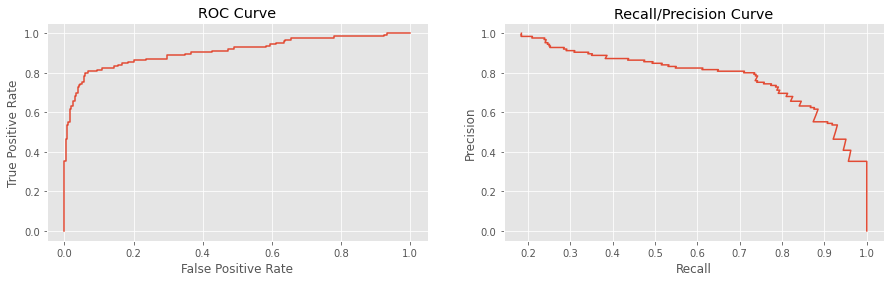

In [24]:
model = SVC(kernel='rbf', C=10, probability=True)

plt.figure(figsize=(15, 4))
aio.modelcurve(X, y, model)

In [45]:
dfModel1 = dfModel.copy()

dfModel1 = dfModel1.drop(['support','support_p1'])
dfModel1 = dfModel1.rename(index={'support_p2': 'support'})

dfModel1.to_csv('dfModel1_support.csv',index=True)

In [46]:
df2 = pd.read_csv('dfModel1_support.csv', index_col=0)
df2

,cross-score,cross-train,train_score,test_score,precision,recall,f1-score,auc-roc,auc-pr
logistic,0.837,0.836,0.838,0.851,0.632,0.344,0.446,0.782,0.541
tree,0.878,0.873,0.895,0.891,0.712,0.632,0.669,0.888,0.713
forest,0.916,0.910,1.000,0.912,0.844,0.608,0.707,0.955,0.859
neural,0.847,0.846,0.855,0.865,0.689,0.408,0.513,0.792,0.595
support,0.907,0.900,0.952,0.912,0.908,0.552,0.687,0.907,0.818


## Sonuç

- Hızlı sonuç alabilek için scale edilmiş data kullanıldı, bu yöntem sayesinde 44dk'dan 3dk'ya indirildi. 
- Scale edilen veri için performansda çok fazla iyileştirme olmadı, çok ufak oynamalar oldu.
- Forest'a göre daha düşük performans gösterdi, ama birkaç parametre iyileştirmesi daha yapılırsa iyi sonuçlar alınabilir. 
- Maliyet odaklı incelenirse tree kadar olmasada, iyi bir performans sergilemediği söylenebilir.
- Parametrik değişiklikler yapıldıktan sonra daha iyi sonuçlar alındı, ama çoklu parametre uygulamak istenirse aşırı zaman gerektirir.
    - kernel: rbf, C: 10